# *Mounting Drive*

In [26]:
# Mounting the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# *Importing required Libraries*

In [54]:
# Importing required libraries

import colorsys
import math
import skimage.io as io
import skimage
from skimage.transform import resize
from skimage.io import imread_collection
import os
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
from math import exp
from scipy.sparse.linalg import eigsh


# *Data*

In [28]:
# Loading the images into a list. both png and jpg
# test_images contains the list of the images on which image segmentation is done

data_dir = '/content/drive/MyDrive/assignment2_data/test_images'
load_pattern = os.path.join(data_dir, '*jpg') + ':' + os.path.join(data_dir, '*png')
test_images = imread_collection(load_pattern)

In [55]:
# BOUND is the distance limit above which weights are set to 0

BOUND =  15 * 15
sigmaI = 10
sigmaX = 15

# *Spatial Distance between two pixels*

In [30]:
# SpatialProx calculates the Spatial Proximity parameter of two pixel locations

def SpatialProx(p1_location, p2_location):
  Distance = (p1_location[0] - p2_location[0]) ** 2
  Distance += (p1_location[1] - p2_location[1]) ** 2

  # If Distance >= BOUND, weights are set to zero
  
  if Distance < BOUND:
    return exp(- Distance / sigmaX)
  else:
    return 0

# *Weight Matrix Elements*

**Intensity**

In [31]:
def WeightElements_intensity(p1, p2, p1_i, p2_i, width):

  # From the flattened image, we retrieve the actual indices and store them in lists

  p1_location = [None] * 2
  p2_location = [None] * 2

  # Retrieve location of pixel 1

  p1_location[0] = int(p1_i / width)
  p1_location[1] = p1_i - p1_location[0] * width

  # Retrieve location of pixel 2

  p2_location[0] = int(p2_i / width)
  p2_location[1] = p2_i - p2_location[0] * width

  # Calculate Distance first and lateron proceed if its not zero
  # Distance made 1 for better results
  
  Distance = 1

  # Pixel intensities are calculated and used for feature similarities
  
  if Distance != 0:
    p1_Intensity = (p1[0] + p1[1] + p1[2]) / 3
    p2_Intensity = (p2[0] + p2[1] + p2[2]) / 3
    FeatSim = abs(p1_Intensity - p2_Intensity) ** 2
    return exp(-FeatSim/ sigmaI) * Distance

  return 0

**Color**

In [56]:
def WeightElements_color(p1, p2):
  
  h1,s1,v1 = colorsys.rgb_to_hsv(p1[0], p1[1], p1[2])
  Feature1 = np.array([v1, v1* s1*math.sin(h1), v1* s1*math.cos(h1) ])

  h2,s2,v2 = colorsys.rgb_to_hsv(p2[0], p2[1], p2[2])
  Feature2 = np.array([v2, v2* s2*math.sin(h2), v2* s2*math.cos(h2) ])
  
  FeatSim = np.linalg.norm(Feature1 - Feature2)
  return exp(-FeatSim ** 2/ sigmaI)

  # return 0

# *Weight Matrix Calculation*

In [47]:
def CalculateWeightMatrix(image, mode):
  
  shape = image.shape

  # Flatten

  R = image[: , : , 0].flatten()
  G = image[: , : , 1].flatten()
  B = image[: , : , 2].flatten()

  flat_size = R.shape[0]

  # Pixels array stores the flattened versions of RGB channels in its columns

  pixels = np.zeros([flat_size, 3])
  pixels[: , 0] = R
  pixels[: , 1] = G
  pixels[: , 2] = B

  # Initialized an array Weights to store weights
  # iteration_count = 0
  # iterations = 0
  Weights = np.zeros([flat_size, flat_size])
  for i in range(flat_size):
    for j in range(i + 1):
      if mode == 'intensity':
        Weights[i, j] = WeightElements_intensity(pixels[i], pixels[j], i , j, shape[1])
        Weights[j, i] = Weights[i, j]
      elif mode == 'color':
        Weights[i, j] = WeightElements_color(pixels[i], pixels[j])
        Weights[j, i] = Weights[i, j]
    # iteration_count += 1
    # if int(iteration_count / 50) > 0:
    #   iterations += iteration_count
    #   print(iterations)
    #   iteration_count = 0 

  return Weights

# *Segmentation*

In [57]:
# Segment function takes an image, segments it and returns it based on color or intensity for similarity calculation

def Segment(image, mode):
  image = resize(image, (50,50))
  W = CalculateWeightMatrix(image, mode)
  D = np.zeros(W.shape)
  for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])
  A = D - W
  B = D
  eigvals, eigvecs = eigsh(A, k = 2, M = B, which = 'SM')
  seg = eigvecs[:,1] > 0
  segmented_image = seg.reshape((image.shape[0], image.shape[1]))
  return segmented_image


# *Visualization*

**Intensity for Similarity Calculation (Rotation and Noise included)**

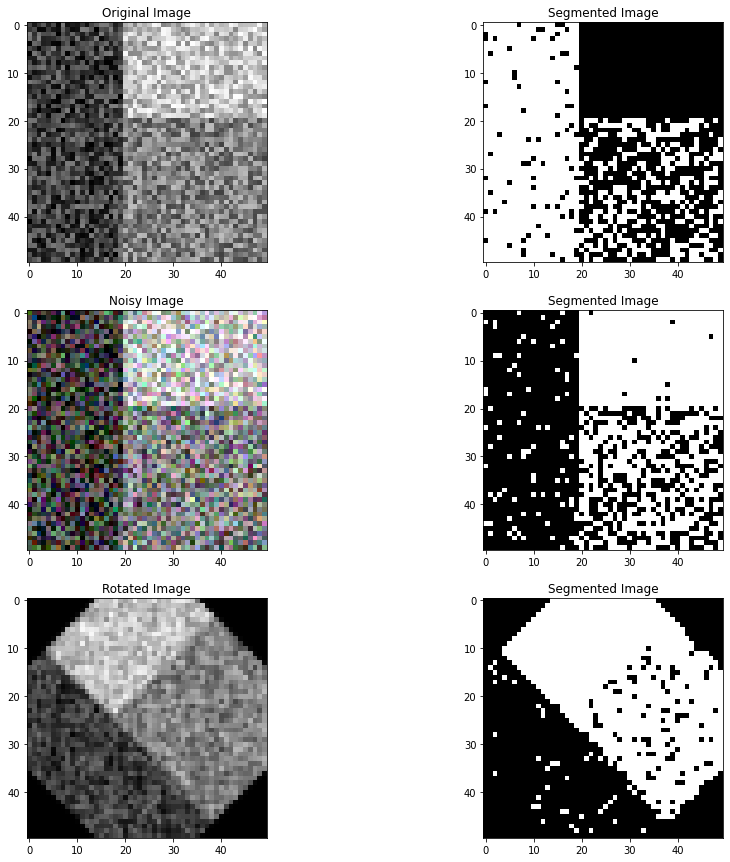

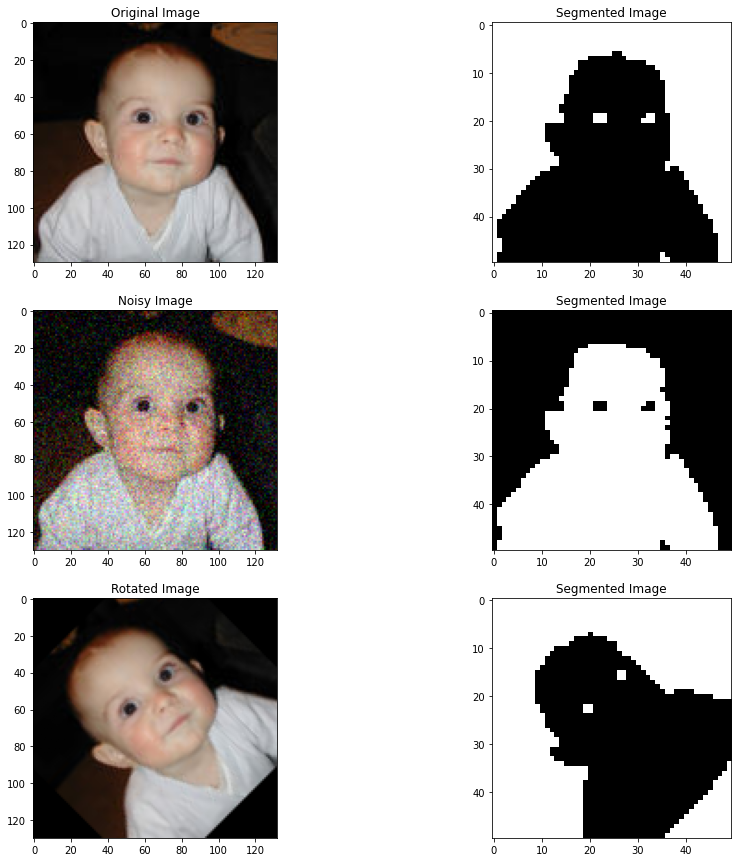

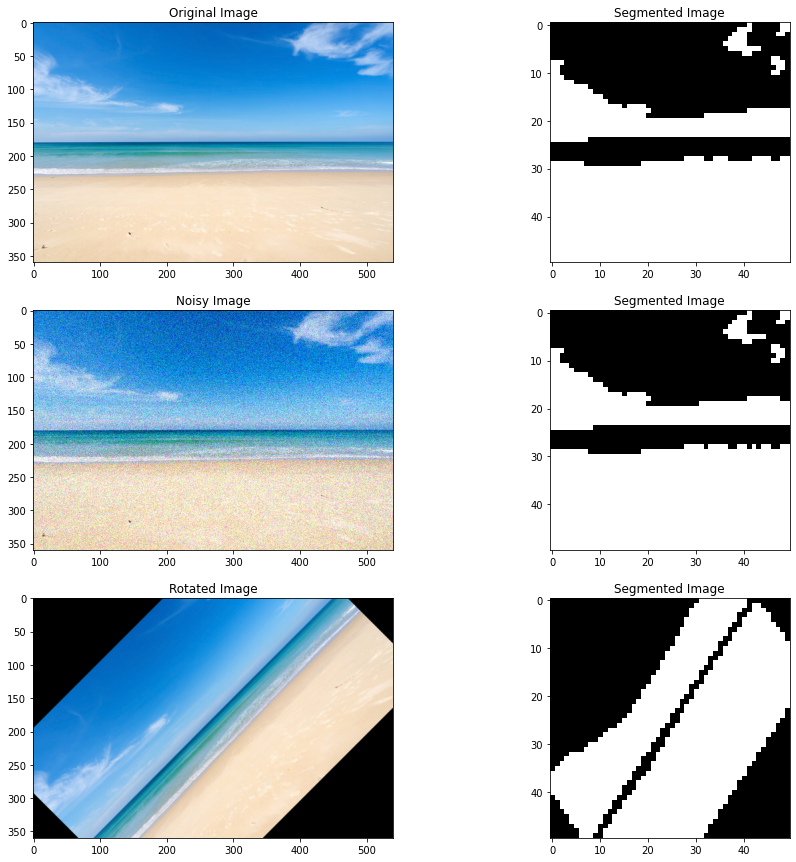

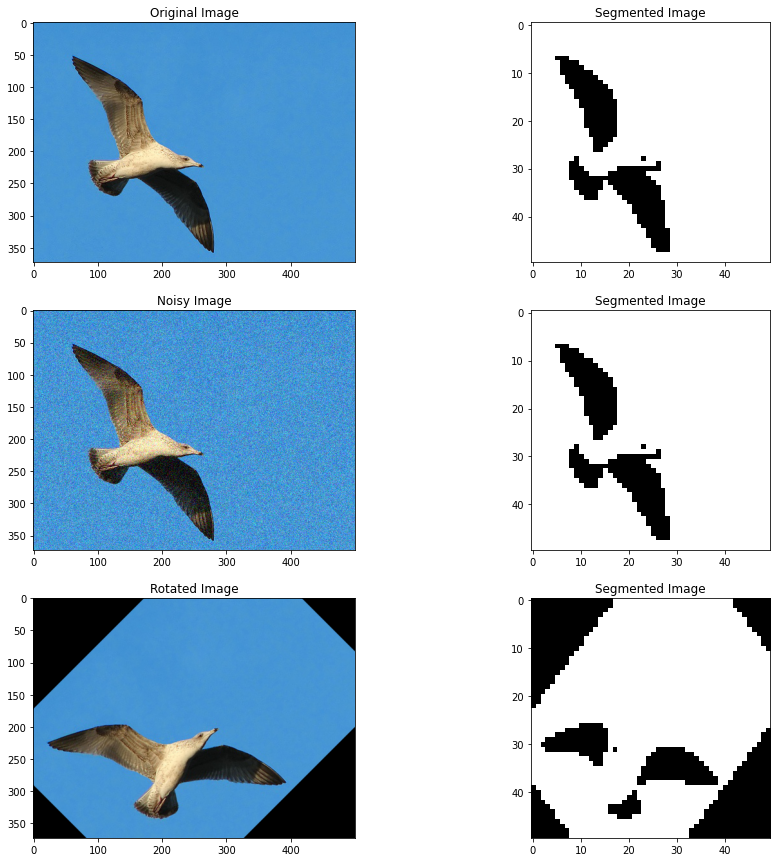

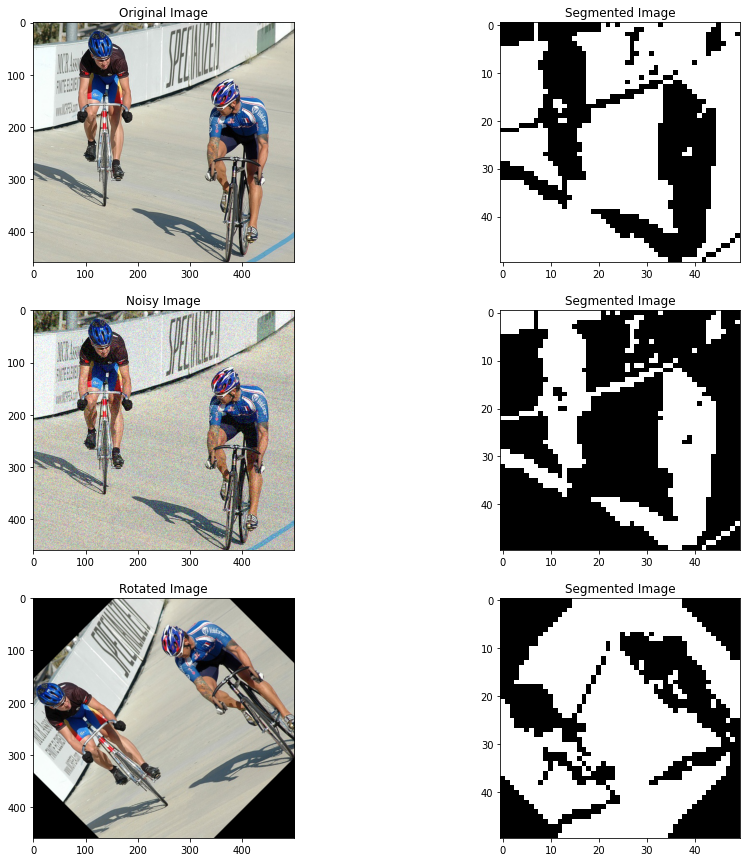

In [35]:
for i in range(len(test_images)):

  image = test_images[i]
  image_noisy = skimage.util.random_noise(image, mode = 'gaussian')
  image_rotated = skimage.transform.rotate(image, 45)

  mask = Segment(image, 'intensity')
  mask_noisy = Segment(image_noisy, 'intensity')
  mask_rotated = Segment(image_rotated, 'intensity')
  
  fig, axis = plt.subplots(nrows = 3, ncols = 2, squeeze = False, figsize = (15,15))
  axis[0,0].imshow(image)
  axis[0,1].imshow(mask, cmap = 'gray')
  axis[1,0].imshow(image_noisy)
  axis[1,1].imshow(mask_noisy, cmap = 'gray')
  axis[2,0].imshow(image_rotated)
  axis[2,1].imshow(mask_rotated, cmap = 'gray')
  axis[0,0].title.set_text('Original Image')
  axis[0,1].title.set_text('Segmented Image')
  axis[1,0].title.set_text('Noisy Image')
  axis[1,1].title.set_text('Segmented Image')
  axis[2,0].title.set_text('Rotated Image')
  axis[2,1].title.set_text('Segmented Image')
  plt.show()

**Color for Similarity Calculation (Rotation and Noise included)**

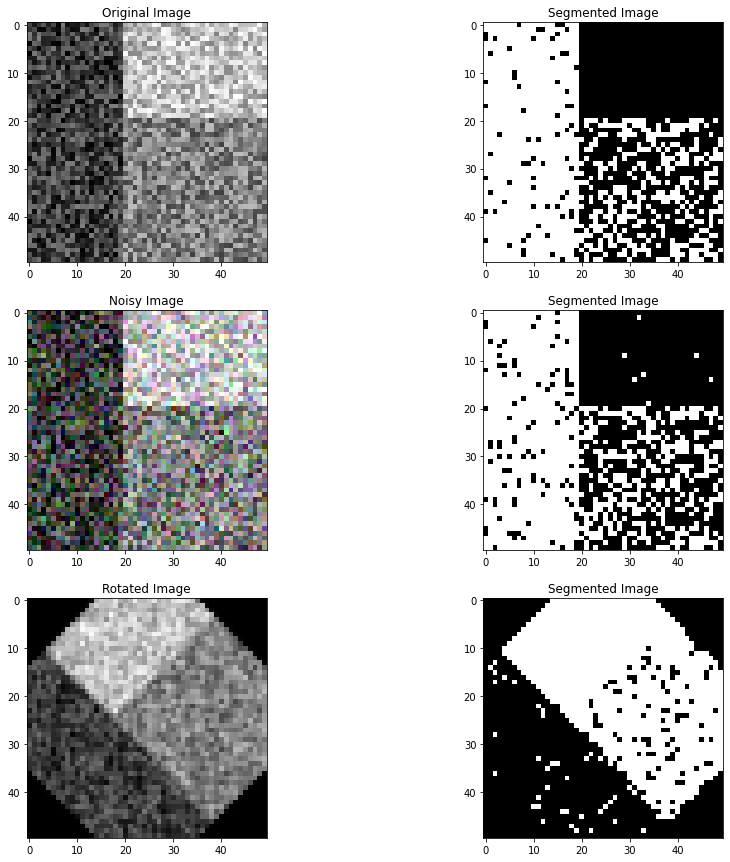

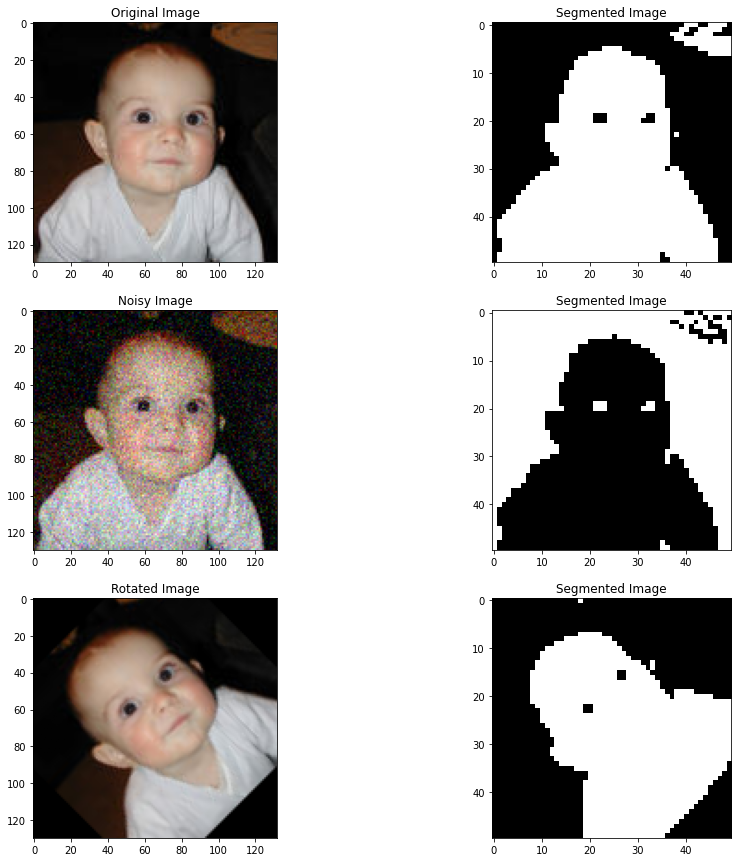

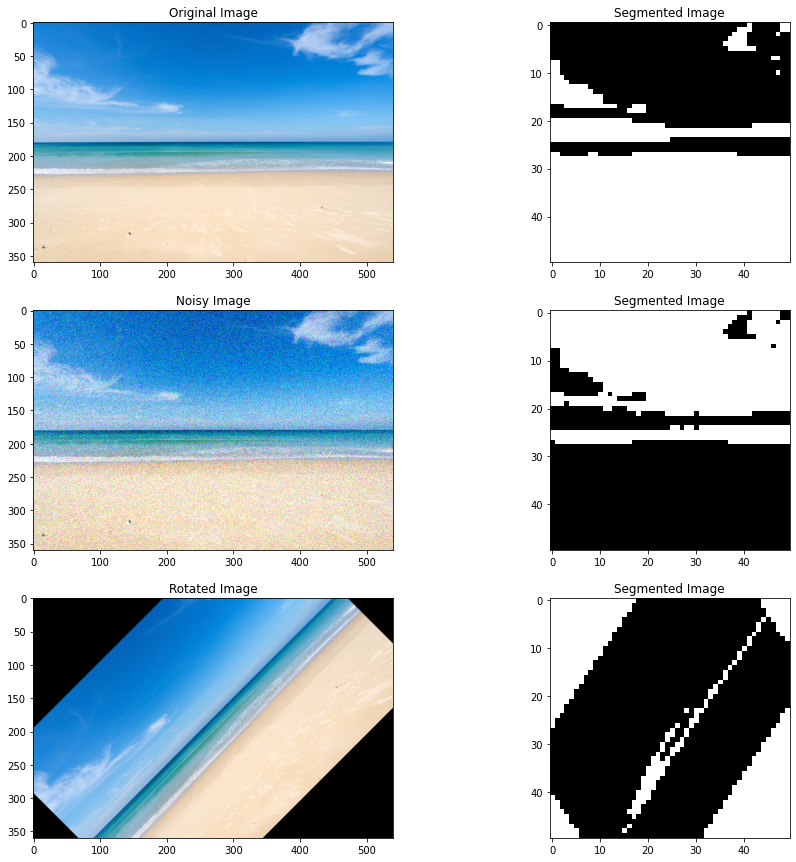

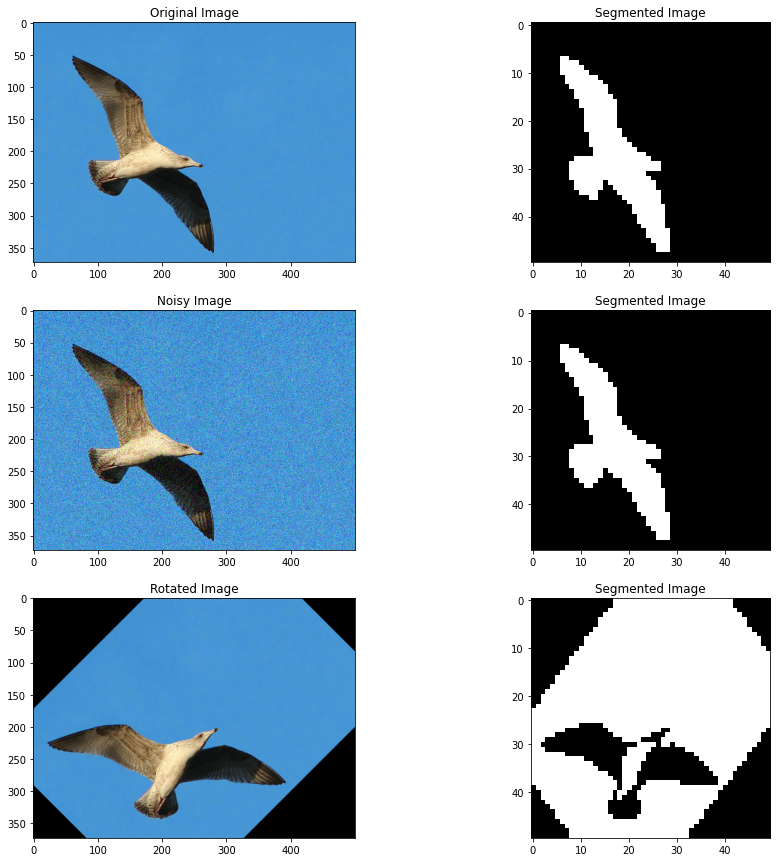

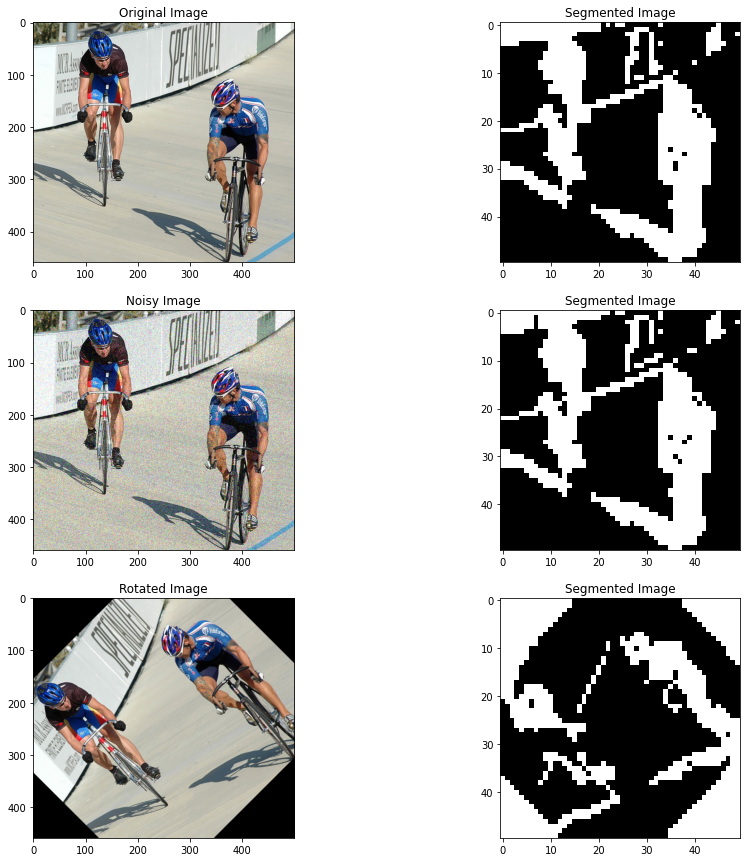

In [53]:
for i in range(len(test_images)):
  image = test_images[i]
  image_noisy = skimage.util.random_noise(image, mode = 'gaussian')
  image_rotated = skimage.transform.rotate(image, 45)

  mask = Segment(image, 'color')
  mask_noisy = Segment(image_noisy, 'color')
  mask_rotated = Segment(image_rotated, 'color')
  
  fig, axis = plt.subplots(nrows = 3, ncols = 2, squeeze = False, figsize = (15,15))
  axis[0,0].imshow(image)
  axis[0,1].imshow(mask, cmap = 'gray')
  axis[1,0].imshow(image_noisy)
  axis[1,1].imshow(mask_noisy, cmap = 'gray')
  axis[2,0].imshow(image_rotated)
  axis[2,1].imshow(mask_rotated, cmap = 'gray')
  axis[0,0].title.set_text('Original Image')
  axis[0,1].title.set_text('Segmented Image')
  axis[1,0].title.set_text('Noisy Image')
  axis[1,1].title.set_text('Segmented Image')
  axis[2,0].title.set_text('Rotated Image')
  axis[2,1].title.set_text('Segmented Image')
  plt.show()